# Optimal Location to Open Orient Restaurant in Seattle
**Mohamad Nael QAWAS**  
"Future" Data Scientist

## Table of contents
1. [Introduction / Business Problem](#introduction)
2. [Data Acquisition](#DataAcquisition)
3. [Methodology](#Methodology)
4. [Results](#Results)
5. [Discussion](#Discussion)
6. [Conclusions](#Conclusions)
7. [Footnotes](#footnotes)

## 1. Introduction / Business Problem <a name="introduction"></a>

### 1.1 - Preface

This research paper is my capstone project (course #9) for the IBM Data Science Professional Certificate.

(https://www.coursera.org/professional-certificates/ibm-data-science#howItWorks).

### 1.2 - Introduction

Orient restaurants are an innovative and healthy Hawaiian cuisine that are seeing growing demand.[1]  Orient “build-your-own” bowl flexibility allows diners to choose from multiple bases[2] (salad, rice or quinoa), multiple protein sources[2] (salmon, tuna, octopus, red snapper, etc.), and multiple toppings[2] (10+ sauces and oils, seeds, onions, cucumbers, crab-salad, seaweed, dices mangoes or oranges, and much more).  Orient bowls generally offer superior nutrition and taste relative to other fast food options[3].

### 1.3 - Business Problem

The objective of this research project is to analyze and select the best location in Seattle for our “hypothetical” client to open a new Orient Restaurant.  S/he already owns and operates one Orient restaurant just North of Seattle and is looking to expand by opening a second somewhere in Seattle.

Searching for the optimal location is challenging because it is not as simple as finding a geographic gap where there is not yet a Orient restaurant.  It is more complex in that potential customers aren’t interested in driving out to an isolated neighborhood with one Orient restaurant; but rather they prefer frequenting common clusters of restaurants(see “clustering” game theory[4]…not to be confused with “clustering” algorithms[5])  However, caution must be taken to carefully select the best location, because there is risk that the Orient market is already oversaturated[6] with 68 Orient restaurants currently in Seattle as per a Google Map search (via jump to last-in-list).[7]

To address this business problem, research will be done using data science methodology and machine learning techniques such as clustering to find and rank the best locations.

### 1.4 - Install Libraries

The following libraries are left uncommented to harmlessly run and pop a messagebox indicating that the library is already installed.  There might be reasons to comment this out however, and if you need to, they are all isolated up here.


In [97]:
#! pip install numpy  

In [98]:
#! pip install pandas

In [99]:
#! pip install matplotlib

In [100]:
#! pip install seaborn

In [101]:
#! pip install sklearn

In [102]:
#! pip install pygeocoder

In [103]:
#! pip install folium==0.5.0

In [104]:
#! pip install geopy

In [105]:
#! pip install pandoc

### 1.5 - Import Libraries

In [106]:
import numpy as np # library to handle data in a vectorized manner
print('Done!')

Done!


In [107]:
import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
print('Done!')

Done!


In [108]:
import requests # library to handle requests
print('Done!')

Done!


In [109]:
from pandas.io.json import json_normalize # library to transform JSON file into a pandas dataframe
print('Done!')

Done!


In [110]:
import matplotlib.cm as cm           # Matplotlib and associated plotting modules
import matplotlib.colors as colors

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter  
from matplotlib.ticker import PercentFormatter  
print('Done!')

Done!


In [111]:
import seaborn as sns # library for data visualization, fancier graphs built on top of matplotlib
print('Done!')

Done!


In [112]:
from sklearn.cluster import KMeans # library for k-means clustering 
print('Done!')

Done!


In [113]:
from pygeocoder import Geocoder
print('Done!')

Done!


In [114]:
from geopy.geocoders import Nominatim
print('Done!')

Done!


In [115]:
import folium

In [116]:
print('Libraries imported.')

Libraries imported.


## 2. Data Acquisition <a name="DataAcquisition"></a>

### 2.1 - Data Needs

To solve the business problem of finding the most suitable location in Seattle, we will need the following data:
* List of neighborhoods in the city of Seattle
* List of zip codes for Seattle
* Latitude and longitude coordinates of those neighborhoods to plot maps and tie in venue data
* Venue data linking geographic context such as restaurant cluster locations, whether a Orient restaurant already exists, average sales, average tips, average like ratings, etc.
* Various demographic metrics for Seattle neighborhoods and/or zip codes to provide context such as population density, rental vs. ownership percentages, median age, urban community type, etc.

### 2.2 - Data Sources

The data sources used in this research project include:
* The **City of Seattle OpenData Urban Centers** [8] CSV download was used to split Seattle up into 42 neighborhoods. Attributes include neighborhood size in acres, population, ethnicity breakdowns, rental vs. home ownership percent, and other demographics.
* The **AgingKingCounty.org**[12] PDF download cross-walks Seattle Neighborhoods to zip codes. 
* The **OpenDataSoft.com**[13] web report was filtered down to a list of all Seattle zip codes along with their latitude and longitude coordinates.  These were exported out to a CSV file for use in this project.  
* The Python **Geocoder** package was used just for a level set map of Seattle.  Decision was made not to use it for the neighborhood zip code to geo coordinates because it would have added a little complexity and development time.  Instead the simpler OpenDataSoft CSV file was used instead. 
* The **Foursquare API**[9] was used to add venue data for the neighborhoods such as number of restuarants, whether or not a Orient restaurant already exists, etc.  Foursquare is one of the largest venue databases having over 105 million[10] global points of interest and 125,000[11] developers building location-aware experiences with the Foursquare API.


## 3. Methodology <a name="Methodology"></a>

### 3.1 - Data Loading

#### 3.1.1 - Load  Seattle Neighborhoods, ZIp Codes, and Demographics from CSV
First, the City of Seattle OpenData Urban Centers[8] CSV file was downloaded containing 42 rows and columns such as neighborhood name, urban type, acres, square miles, total population, ethnicity breakdown, median age, housing units, number of renters, number of home owners, number of vacancies, etc.  The initial plan was to directly download the CSV from python code (wget), but after the timebox was exceeded then a decision was made to simply manually download the CSV file.

Next, zip codes for each neighborhood were pulled from the AgingKingCounty[12] PDF file.  Because this was a PDF file, it quickly became evident it would be faster to manually added the 42 zip codes to the existing CSV rather than get fancy writing python code to parse a PDF.  Some Neighborhoods spanned multiple zip codes.  Some zip codes spanned multiple neighborhoods.  The combination resulted in 46 rows from the base set of 42.  These would need to be de-duped and grouped later in code as part of data wrangling.

Next, the combined CSV file was compared to an actual online zip code map of Seattle.  Two zip codes and neighborhoods were missing and were added, bringing the total to 48 neighborhood/zip code rows.  Unfortunately, they were not present in the City of Seattle base set and thus were later removed.

After the data was manually consolidated into one CSV file, it was populated into Pandas DataFrames using the Pandas read_csv command.  One column was dropped, and one was renamed.  The data was verified using a “print(DataFrame.shape)” command to confirm expected row and  column counts, as well as a “DataFrame.head()” to spot check the top 5 rows.

In [117]:
# Load CSV into DataFrame
df_X = pd.read_csv("seattle_neighborhoods_zipcodes_geoloc_demographics.csv", dtype={"Zipcode":str})

# Drop Column "OBJECTID"
del df_X['OBJECTID']

# Rename the columns
df_raw = df_X.rename(columns = {'Type_Name':'Type'})
                                               
# Verify
print(df_raw.shape)
df_raw.head()

(41, 10)


,Zipcode,Borough,Neighborhood,Type,Acres,Total_Pop,Median_Age,Occ_Units,Owner_Occ,Renter_Occ
0,0,x,23rd and Union-Jackson,Residential Urban Village,516.6,9468,37.4,4422,1701,2721
1,0,x,12th Avenue,Urban Center Village,159.8,4519,30.6,1758,203,1555
2,98146,Southwest,WestSeattle,Hub Urban Village,225.8,3788,42.9,2324,752,1572
3,98102,LakeUnion,Eastlake,Residential Urban Village,200.2,5084,37.0,3118,878,2240
4,98101,Downtown,CommCore,Urban Center Village,276.4,5917,45.9,2985,662,2323


#### 3.1.2 - Load Seattle Geo Coordinates by Zip Code from CSV
Next, the OpenDataSoft[13] website allowed filtering down to just zip codes in Seattle which were then exported out to a CSV file.  These also were loaded into a Pandas DataFrame and verified 

In [118]:
# Load CSV into DataFrame
df_X = pd.read_csv("seattle_zipcode_latitude_longitude.csv", dtype={"Zipcode":str})

# New subset DataFrame with just the columns we want to extract out of df_sea_neigh_raw
df_X2 = df_X[["Zipcode", "Latitude", "Longitude"]]

# Convert Zipcode to index so subsequent step can merge
df_coord = df_X2[['Zipcode','Latitude','Longitude']].groupby('Zipcode').min()

# Verify
print(df_coord.shape)
df_coord.head()

(25, 2)


,Latitude,Longitude
Zipcode,,
98101,47.610670,-122.33438
98102,47.632870,-122.32253
98103,47.671346,-122.34166
98104,47.602520,-122.32855
98105,47.663770,-122.30118


### 3.2 - Data Cleaning

#### 3.2.1 - Remove Missing, Null, or Blank Values Rows
Next, rows haing Zipcode = 0 were dropped.  Also, rows having NaN or Null rows at critical fields Borough, Neighborhood, and Type were also dropped.  The data set dropped from 41 neighborhood rows down to 39 rows.

In [119]:
# Delete rows with bogus values that cause errors downstream
df_clean = df_raw.drop(df_raw[df_raw.Zipcode=="0"].index)
df_clean = df_clean.dropna(subset=['Type']).reset_index(drop=True)

# Verify
print(df_clean.shape)
df_clean.head()

(39, 10)


,Zipcode,Borough,Neighborhood,Type,Acres,Total_Pop,Median_Age,Occ_Units,Owner_Occ,Renter_Occ
0,98146,Southwest,WestSeattle,Hub Urban Village,225.8,3788,42.9,2324,752,1572
1,98102,LakeUnion,Eastlake,Residential Urban Village,200.2,5084,37.0,3118,878,2240
2,98101,Downtown,CommCore,Urban Center Village,276.4,5917,45.9,2985,662,2323
3,98122,East,IntDistrict,Urban Center Village,171.3,3466,52.3,2227,104,2123
4,98121,Downtown,Belltown,Urban Center Village,219.9,11961,39.8,8421,1982,6439


#### 3.2.2 - Data De-Duped and Rolled Up to Zip Codes
Next, data was rolled up to one zip code per row.  Rollup string type fields Neighborhoods, boroughs, and Types using concatenation into comma delimited descriptions.  Rollup numeric fields Acres, Total_Pop, Occ_Units, Owner_Occ, and Renter_Occ via the aggregate SUM function.  Finally,  rollup Median Age using the aggregate AVERAGE function.  The 39 neighborhood rows dropped down to 25 rolled up zip code rows with the Boroughs, Neighborhoods, and Types columns all clearly having comma delimited list values where before there were multiple rows.  The aggregated numeric fields were also tacked on to the right of the DataFrame.

In [120]:
# Derive comma separate list of Boroughs per Zipcode
df_X = df_clean[['Zipcode','Borough']]
df_X2 = df_X.join(df_X.Zipcode.map(df_X.groupby('Zipcode').Borough.unique().str.join(', ')).rename('Boroughs'))
df_zip_boroughs = df_X2[['Zipcode','Boroughs']].groupby('Zipcode').min()

#df_zip_boroughs.head()

# Derive comma separate list of Neighborhoods per Zipcode
df_X = df_clean[['Zipcode','Neighborhood']]
df_X2 = df_X.join(df_X.Zipcode.map(df_X.groupby('Zipcode').Neighborhood.unique().str.join(', ')).rename('Neighborhoods'))
df_zip_hoods = df_X2[['Zipcode','Neighborhoods']].groupby('Zipcode').min()

#df_zip_hoods.head()

# Derive comma separate list of Types per Zipcode
df_X = df_clean[['Zipcode','Type']]
df_X2 = df_X.join(df_X.Zipcode.map(df_X.groupby('Zipcode').Type.unique().str.join(', ')).rename('Types'))
df_zip_types = df_X2[['Zipcode','Types']].groupby('Zipcode').min()

#df_zip_types.head()

# Combine 3 String fields by Zipcode
df_zip_3str = pd.merge(df_zip_boroughs, df_zip_hoods, on="Zipcode", how="left")
df_zip_3str = pd.merge(df_zip_3str, df_zip_types, on="Zipcode", how="left")

# Verify
print(df_zip_3str.shape)
df_zip_3str.head()

(25, 3)


,Boroughs,Neighborhoods,Types
Zipcode,,,
98101,"Downtown, East","CommCore, PikePine, DennyTriangle",Urban Center Village
98102,LakeUnion,Eastlake,Residential Urban Village
98103,"LakeUnion, Northwest","Wallingford, AuroraNorth, Fremont","Residential Urban Village, Hub Urban Village"
98104,"Downtown, East","MadisonMiller, FirstHill, PioneerSquare","Residential Urban Village, Urban Center Village"
98105,Northeast,Admiral,Residential Urban Village


In [121]:
# Append Columns 'Acres', 'Total_Pop', etc. as SUM()'s and 'Median_Age' as MEAN() rolled up to Zipcode level
df_base = pd.merge(df_zip_3str, df_clean.groupby('Zipcode')['Acres'].sum(), on="Zipcode", how="left")
df_base = pd.merge(df_base, df_clean.groupby('Zipcode')['Total_Pop'].sum(), on="Zipcode", how="left")
df_base = pd.merge(df_base, df_clean.groupby('Zipcode')['Occ_Units'].sum(), on="Zipcode", how="left")
df_base = pd.merge(df_base, df_clean.groupby('Zipcode')['Owner_Occ'].sum(), on="Zipcode", how="left")
df_base = pd.merge(df_base, df_clean.groupby('Zipcode')['Renter_Occ'].sum(), on="Zipcode", how="left")
df_base = pd.merge(df_base, df_clean.groupby('Zipcode')['Median_Age'].mean(), on="Zipcode", how="left")

# Verify
print(df_base.shape)
df_base.head()

(25, 9)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Occ_Units,Owner_Occ,Renter_Occ,Median_Age
Zipcode,,,,,,,,,
98101,"Downtown, East","CommCore, PikePine, DennyTriangle",Urban Center Village,550.0,13578,8134,1769,6365,38.133333
98102,LakeUnion,Eastlake,Residential Urban Village,200.2,5084,3118,878,2240,37.000000
98103,"LakeUnion, Northwest","Wallingford, AuroraNorth, Fremont","Residential Urban Village, Hub Urban Village",798.6,15489,8167,2742,5425,33.566667
98104,"Downtown, East","MadisonMiller, FirstHill, PioneerSquare","Residential Urban Village, Urban Center Village",515.8,14999,8791,1491,7300,39.833333
98105,Northeast,Admiral,Residential Urban Village,98.3,1528,962,259,703,42.300000


#### 3.2.3 - Calculate Densities and Percent Rental Units
Next, three density columns "Dens_Tot_Pop", "Dens_Home_Own", and "Dens_Apt_Dw" were calculated given the Acres per Zipcode, the total population, and the number of owner occupied and renter occupied unit counts.  To cleanup this new Base DataFrame, the interim fields "Owner_Occ" and "Renter_Occ" were dropped, leaving only those fields desirable in the final output.  Base DataFrame remains at 25 rows, but now has 9 columns.

In [122]:
# Calculate three densities and tack on percent Rental units
df_base["Pop_Dens"] = df_base["Total_Pop"] / df_base["Acres"]
df_base["Prc_Own"] = df_base["Owner_Occ"] / df_base["Occ_Units"]
df_base["Prc_Rent"] = df_base["Renter_Occ"] / df_base["Occ_Units"]

# Strip down to just the columns we need to carry forward 
# New subset DataFrame with just the columns we want to extract out of df_sea_neigh_raw
df_base = df_base[["Boroughs","Neighborhoods","Types","Acres","Total_Pop","Median_Age", 
                    "Pop_Dens","Prc_Own","Prc_Rent"]]

# Verify Results
print(df_base.shape)
df_base.head()

(25, 9)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent
Zipcode,,,,,,,,,
98101,"Downtown, East","CommCore, PikePine, DennyTriangle",Urban Center Village,550.0,13578,38.133333,24.687273,0.217482,0.782518
98102,LakeUnion,Eastlake,Residential Urban Village,200.2,5084,37.000000,25.394605,0.281591,0.718409
98103,"LakeUnion, Northwest","Wallingford, AuroraNorth, Fremont","Residential Urban Village, Hub Urban Village",798.6,15489,33.566667,19.395192,0.335741,0.664259
98104,"Downtown, East","MadisonMiller, FirstHill, PioneerSquare","Residential Urban Village, Urban Center Village",515.8,14999,39.833333,29.079100,0.169605,0.830395
98105,Northeast,Admiral,Residential Urban Village,98.3,1528,42.300000,15.544252,0.269231,0.730769


#### 3.2.4 - Add Seattle Zip Code Geo Coordinates to Base DataFrame
Next, the two geo coordinates latitude and longitude are merged in to the base data frame from the dataframe loaded in 3.1.2.   The row count remains at 25, but the column count increased up to 11.

In [123]:
# Merge these coordinates into the main zip data frame
df_seattle = pd.merge(df_base, df_coord, on="Zipcode", how="right")

# Verify final shape
print(df_seattle.shape)
df_seattle.head()

(25, 11)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude
Zipcode,,,,,,,,,,,
98101,"Downtown, East","CommCore, PikePine, DennyTriangle",Urban Center Village,550.0,13578,38.133333,24.687273,0.217482,0.782518,47.610670,-122.33438
98102,LakeUnion,Eastlake,Residential Urban Village,200.2,5084,37.000000,25.394605,0.281591,0.718409,47.632870,-122.32253
98103,"LakeUnion, Northwest","Wallingford, AuroraNorth, Fremont","Residential Urban Village, Hub Urban Village",798.6,15489,33.566667,19.395192,0.335741,0.664259,47.671346,-122.34166
98104,"Downtown, East","MadisonMiller, FirstHill, PioneerSquare","Residential Urban Village, Urban Center Village",515.8,14999,39.833333,29.079100,0.169605,0.830395,47.602520,-122.32855
98105,Northeast,Admiral,Residential Urban Village,98.3,1528,42.300000,15.544252,0.269231,0.730769,47.663770,-122.30118


#### 3.2.5 - Checkpoint
Verify the dataset looks good.  Save it out to CSV locally.  Noticed that field Total_Pop was type "float".  Converted it over to type "Integer" so no trailing decimal point (cannot have a fractional person).

In [124]:
# Verifications below caught issue where Total_Pop was float but really should be int...fixing here, then re-verify below
df_seattle.Total_Pop = df_seattle.Total_Pop.astype(int)

In [125]:
# Verify basic info
df_seattle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 98101 to 98199
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Boroughs       25 non-null     object 
 1   Neighborhoods  25 non-null     object 
 2   Types          25 non-null     object 
 3   Acres          25 non-null     float64
 4   Total_Pop      25 non-null     int32  
 5   Median_Age     25 non-null     float64
 6   Pop_Dens       25 non-null     float64
 7   Prc_Own        25 non-null     float64
 8   Prc_Rent       25 non-null     float64
 9   Latitude       25 non-null     float64
 10  Longitude      25 non-null     float64
dtypes: float64(7), int32(1), object(3)
memory usage: 2.2+ KB


In [126]:
df_seattle.to_csv('seattle_neighborhoods_checkpoint.csv')

### 3.3 - Data Exploration
#### 3.3.1 - Explore Base Dataset in Map of Seattle
Next, we spun up a map of Seattle using the Folium library.  Markers were established by dropping in our zip code based geo-coordinates from the DataFrame above to make sure the preliminary dataset all looks good.  As it turned out, there was a gross outlier with one of the zip codes being more than 100 miles out of place.  Using this technique was easy to catch and correct the typo.  Afterwards, the map looks good with uniform coverage of all zip codes across the City of Seattle.

In [127]:
# Get Geographic Coordinates of Seattle
address = "Seattle"
geolocator = Nominatim(user_agent='us_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Seattle are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Seattle are 47.6038321, -122.3300624.


In [128]:
# NOTE - This step caught an error with zipcode vs. latitude/longitude mappings...an outlier...corrected CSV and re-ran

# create map of Toronto using latitude and longitude values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10, width=500, height=500)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_seattle['Latitude'], df_seattle['Longitude'], df_seattle['Boroughs'], df_seattle['Neighborhoods']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  

map_seattle

#### 3.3.2 - Setup Foursquare for Use
For this IBM training course, I had to setup a set of one-time / throw-away credentials to the Foursquare API.  Those are used as well as a generic function to call the FourSquare API that was pulled from the course lab code.  Both are run, but do not yield any output.

In [129]:
# Setup my throw-away credentials for this project
CLIENT_ID = '52JKLAGJPSSWR4YQ3CVLUHCKAOKQJXS5WJJ03WTBVYL1EYH4' # your Foursquare ID
CLIENT_SECRET = 'QKS1ZH4F4KUUGK4WB402PUKBYADMCJWJIFMZUJR0ZRDZZKYO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 52JKLAGJPSSWR4YQ3CVLUHCKAOKQJXS5WJJ03WTBVYL1EYH4
CLIENT_SECRET:QKS1ZH4F4KUUGK4WB402PUKBYADMCJWJIFMZUJR0ZRDZZKYO


This is the generic Function To Call Foursquare API and return Nearby Venues

In [130]:
# Generic Function
def getNearbyVenues(cities, names, latitudes, longitudes, LIMIT=100, radius=500):
    # boroughs   = dataframe column filled with borough (city) names
    # names      = dataframe column filled with neighborhood names or zipcodes or bureuas
    # latitudes  = dataframe column filled with latitudes mapping directly to the names
    # longitudes = dataframe column filled with longitudes mapping directly to the names
    # LIMIT      = default is 100, limit the number of venues found per input row (name/lat/long combinations)
    # radius     = detault is 500, limits db search to this many meters...note that a city block is 80 meters, 
    venues_list=[]
    for city, name, lat, lng in zip(cities, names, latitudes, longitudes):
        print(city + ': ' + name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    df_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    df_venues.columns = ['Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(df_venues)

#### 3.3.3 - Call FourSquare API to Fetch Venues For Seattle Neighborhoods
Next, the FourSquare API was called for each Seattle neighborhood zip code.  Our FourSquare request was limited to just the top 100 most common venues per request because that is more than sufficient for our analysis, and to avoid cap on daily request size.  Our FourSquare request was also limited to 1,600 meters which is equivalent to 1 mile or 20 blocks at 80 meters per city block.

FourSquare streams its Response back line by line to Python / the Jupyter Notebook as it works thru each zip code in the API Request (Fig. 3.3.3.a).  The final response is collected in a Pandas DataFrame consisting of 2,055 rows and 8 columns.  The first four columns are the input parameters for Neighborhood (Borough, Name, Latitude, and Longitude).  FourSquare appends four additional columns for Venue (Name, Latitude, Longitude, and Category) as shown in Fig. 3.3.3.b. 
Oh, and a side note…you might run into an issue where your firewall blocks the FourSquare API call out from Python or your Jupyter Notebook.   If that happens and you get an error running the code, act accordingly.

In [131]:
# IMPORTANT - Your firewall may block this application from making API calls out...if so, add an exception (or temp. turn off)

# Will use radius = 1,600 or 20 block radious x 80 meters/block

# Call generic function with parameters dialed in to our locations of interest (Neighborhoods)
seattle_venues_raw = getNearbyVenues(cities=df_seattle['Boroughs'],
                            names=df_seattle['Neighborhoods'],
                            latitudes=df_seattle['Latitude'],
                            longitudes=df_seattle['Longitude'],
                            LIMIT=100,
                            radius=1600  
                            )

Downtown, East: CommCore, PikePine, DennyTriangle
LakeUnion: Eastlake
LakeUnion, Northwest: Wallingford, AuroraNorth, Fremont
Downtown, East: MadisonMiller, FirstHill, PioneerSquare
Northeast: Admiral
Delridge: Westwood
Ballard: Ballard
Duwamish: SouthPark
LakeUnion: S_LakeUnion
Northeast, Northwest: Ravenna, GreenLake, Roosevelt
Ballard, Northwest: CrownHill, Grnwd_Phinney
Southeast, Duwamish: Othello, ColumbiaCity
Downtown: Uptown
Downtown: Belltown
East: IntDistrict, CapitolHill
North, Northwest: LakeCity, Northgate
Southwest: MorganJunc
Northwest: BitterLake
Duwamish: BeaconHill
Southwest: WestSeattle
Southeast: NorthRainier
Southeast: RainierBeach
Duwamish: Duwamish
Northeast: UnivDistrict, UnivCampus
QueenAnne: QueenAnne


In [132]:
# Verify Results
print(seattle_venues_raw.shape)
seattle_venues_raw.head()

(2021, 8)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,ACT Theatre,47.610763,-122.332905,Theater
1,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,Penelope and The Beauty Bar,47.608117,-122.333872,Spa
2,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,Monorail Espresso,47.610828,-122.335048,Coffee Shop
3,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,The Capital Grille,47.608115,-122.335077,American Restaurant
4,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,Gelatiamo,47.608754,-122.336992,Dessert Shop


In [133]:
# Spot Check Neighborhood counts -- this led me to researching parameter radius = meters and settling on 20 blocks (1 mile)
#                                   to increase the number of hits (dfeault 500m had just 2 hits on one row)
#seattle_venues_raw.groupby(["Borough", "Neighborhood"]).count()

In [134]:
# Sanity Check for number of unique categories (expect more than 50)
print("Number of Unique Categories: ", len(seattle_venues_raw["Venue Category"].unique()))

Number of Unique Categories:  268


### 3.3.4 - Feature Selection: Clean Venue Data
Thought we were done cleaning data back in Section 2?  Not so fast.  Turns out that the API Response JSON from Folium can use some cleanup too.  Since this isn’t technically source data, and it can’t be requested until the source data was cleaned in Section 2, then we have to wrangle it here.

The first step was to make a copy (not a reference, but a truly separate copy) of the DataFrame housing our FourSquare venue data.  This was important to avoid repeatedly making FourSquare calls as I debugged and then accidentally exceeding the daily cap in API requests.

Next, a Venue Removal Scrub was created.  I called the DataFrame.head(100) to walk the data and start either discarding rows that would clutter the research (don’t care about museums and shops and hotels and schools).  Our goal is to find clusters of other restaurants or food related businesses where there is not already a Orient restaurant existing.  So I built a large array of 77 venue category keywords to discard, and then fed them into a small two line python loop that dropped the venues from 2,055 rows in the original response down to 955 rows of applicable venues.  This tightened up accuracy.  
Next, a Venue Name Consolidation Scrub was created to standardize 92 FourSquare Venue Group names.  This ultimately collapsed the bar graph down to a more manageable set of 40+/- groups from the original 278 pulled down at the end of step 3.3.3.

Both of these scrubs were highly iterative in that a first pass was made, and then 30-40 elements were added as I ran and re-ran the code in stages below.  As the output tables and graphs got refined, I’d see more and more labels that were too long or should be grouped with other labels.  Creating both of these as easily editable lists minimized copy-paste effort and risk.


In [135]:
# IMPORTANT - Make a copy of DataFrame seattle_venues...so as I write the code, if make mistake do not have to re-call the
#             API and burn thru my daily allowance
seattle_venues = seattle_venues_raw[:].copy()

# Verify
print(seattle_venues.shape)
seattle_venues.head()

(2021, 8)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,ACT Theatre,47.610763,-122.332905,Theater
1,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,Penelope and The Beauty Bar,47.608117,-122.333872,Spa
2,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,Monorail Espresso,47.610828,-122.335048,Coffee Shop
3,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,The Capital Grille,47.608115,-122.335077,American Restaurant
4,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,Gelatiamo,47.608754,-122.336992,Dessert Shop


In [136]:
#--------------------------------------
# Removal Scrub
#--------------------------------------

# Our focus is on Restaurants and Related food type services for clustering; therefore, drop all categories (rows)
# like stadiums or art galleries

drop_keywords = ['Service','Shop','Store','Hotel','Museum','Court','Stadium','Theater','Hall','Bookstore'
                 ,'Garden','Park','Zoo','Spa','Grocery','Bus ','Gym','ATM'
                 ,'Playground','Station','Golf','Studio','Market','Club','Lookout','Airport','Doctor'
                 ,'Chiropractor','Dent','Pharmacy','Rental','Fountain','Trail','Center','Dealership'
                 ,'Gallery','Athletics','Baseball','Ferry','Boutique','Bowling','Arcade','Building','Bank'
                 ,'Beach','Campground','Canal','Exhibit','Marijuana','Martial Arts','Landmark','Intersection'
                 ,'Library','Nail Salon','Venue','Office','Pier','River','Supermarket','Barbershop','Soccer'
                 ,'Roller Rink','Other Nightlife','Waterfront','Plaza','Lake','Dog Run'
                 ,'Outdoor Sculpture','Opera House','Field','Historic Site','High School','Pool','Storage Facility'
                 ,'Nature Preserve','Track','Public Art']

for item in drop_keywords:
    seattle_venues = seattle_venues[seattle_venues["Venue Category"].str.contains(item)==False]

# Was using this list to determine what rows to delete above
#seattle_venues["Venue Category"]

# Verify reduction down to 1,253 venues from 2,332 for better restaurant related accuracy
print(seattle_venues.shape)
seattle_venues.head()

(968, 8)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,The Capital Grille,47.608115,-122.335077,American Restaurant
5,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,Din Tai Fung Dumpling House,47.612819,-122.335273,Dumpling Restaurant
6,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,Dough Zone Dumpling House,47.613386,-122.332231,Dumpling Restaurant
11,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,Purple Café & Wine Bar,47.608086,-122.334955,Wine Bar
12,"Downtown, East","CommCore, PikePine, DennyTriangle",47.61067,-122.33438,Café Nordstrom,47.612348,-122.336334,Café


In [137]:
# Use these results to "Tune" the Drop Scrub above and the Naming Consolidation Scrub below...then comment out when done using for design.
#seattle_venues['Venue Category'].unique()

In [138]:
#--------------------------------------
# Naming Consolidation Scrub
#--------------------------------------

# Renames values of categories to shorter names that are more readable in the output tables and graphs,
# as well as consolidate multiple highly granular types into groups of similar types so that graphs aren't too busy.
seattle_venues = seattle_venues.replace({'Venue Category': {'Japanese Restaurant': 'Japanese', 
                                                 'Vietnamese Restaurant': 'Vietnamese',
                                                 'Sushi Restaurant': 'Seafood Sushi', 
                                                 'Seafood Restaurant': 'Seafood Sush',
                                                 'Ramen Restaurant': 'Asian',
                                                 'Asian Restaurant': 'Asian', 
                                                 'Udon Restaurant': 'Asian', 
                                                 'Chinese Restaurant': 'Chinese',
                                                 'Vegetarian / Vegan Restaurant': 'Veget/Vegan',
                                                 'Korean Restaurant': 'Korean',
                                                 'Thai Restaurant': 'Thai',
                                                 'Mexican Restaurant': 'Mexican',
                                                 'Sandwich Place': 'Sandwich',
                                                 'Pizza Place': 'Pizza',
                                                 'Irish Pub': 'Bar',
                                                 'Indian Restaurant': 'Indian',
                                                 'African Restaurant': 'Food Misc',
                                                 'American Restaurant': 'American',
                                                 'Middle Eastern Restaurant': 'Mediterranean',
                                                 'Greek Restaurant': 'Mediterranean',
                                                 'Italian Restaurant': 'Italian',
                                                 'Mediterranean Restaurant': 'Mediterranean',
                                                 'South American Restaurant': 'Caribbean',
                                                 'Eastern European Restaurant': 'Mediterranean',
                                                 'Deli / Bodega': 'Deli',
                                                 'Cajun / Creole Restaurant': 'Cajun',
                                                 'Australian Restaurant': 'Food Misc',
                                                 'Ethiopian Restaurant': 'Ethiopian',
                                                 'Dumpling Restaurant': 'Chinese',
                                                 'Fast Food Restaurant': 'Fast Food',
                                                 'Gaming Cafe': 'Café',
                                                 'Breakfast Spot	': 'Café',
                                                 'Breakfast Spot': 'Café',
                                                 'Dive Bar': 'Bar',
                                                 'Burrito Place': 'Mexican',
                                                 'Burger Joint': 'Burgers',
                                                 'French Restaurant	': 'French',
                                                 'French Restaurant': 'French',
                                                 'New American Restaurant': 'American',
                                                 'Cocktail Bar': 'Bar',
                                                 'Scandinavian Restaurant': 'Food Misc',
                                                 'Scandinavian Restaurant	': 'Food Misc',
                                                 'Turkish Restaurant': 'Mediterranean',
                                                 'Turkish Restaurant	': 'Mediterranean',
                                                 'Veget/Vegan': 'Veggie',
                                                 'Wine Bar': 'Bar',
                                                 'Salad Place': 'Veggie',
                                                 'Brewery': 'Bar',
                                                 'Restaurant': 'Food Misc',
                                                 'Taco Place': 'Mexican',
                                                 'Food Stand': 'Food Cart',
                                                 'Food Truck': 'Food Cart',
                                                 'Lounge': 'Bar',
                                                 'Pub': 'Bar',
                                                 'Veget/Vegan': 'Veggie',
                                                 'Cafe': 'Café',
                                                 'Caribbean Restaurant': 'Caribbean',
                                                 'Fried Chicken Joint': 'Fast Food',
                                                 'Bed & Breakfast': 'Café',
                                                 'Bistro': 'Café',
                                                 'Snack Place': 'Food Misc',
                                                 'Ramen': 'Asian',
                                                 'Indonesion': 'Asian',
                                                 'Southern / Soul Food Restaurant': 'Cajun',
                                                 'Wings Joint': 'Fast Food',
                                                 'Noodle House': 'Asian',
                                                 'Dumplings': 'Asian',
                                                 'Beer Bar': 'Bar',
                                                 'Hot Dog Joint': 'Fast Food',
                                                 'Tapas Restaurant': 'Mexican',
                                                 'Gastropub': 'Bar',
                                                 'Hawaiian Restaurant': 'Caribbean',
                                                 'Soup Place': 'Food Misc',
                                                 'Latin American Restaurant': 'Caribbean',
                                                 'Sports Bar': 'Bar',
                                                 'Sri Lankan Restaurant': 'Mediterranean',
                                                 'Karaoke Bar': 'Bar',
                                                 'Tex-Mex Restaurant': 'Mexican',
                                                 'German Restaurant': 'Food Misc',
                                                 'Whisky Bar': 'Bar',
                                                 'Comfort Food Restaurant': 'American',
                                                 'Indonesian Restaurant': 'Asian',
                                                 'Szechuan Restaurant': 'Asian',
                                                 'Hotpot Restaurant': 'Asian',
                                                 'Tea Room': 'Asian',
                                                 'Food': 'Food Misc',
                                                 'Juice Bar': 'Food Misc',
                                                 'Moroccan Restaurant': 'Food Misc',
                                                 'Winery': 'Bar',
                                                 'Distillery': 'Bar',
                                                 'Creperie': 'Bakery',
                                                 'Falafel Restaurant': 'Mediterranean'
                                                           }})

seattle_venues.tail(5)

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2003,QueenAnne,QueenAnne,47.64767,-122.39758,Pandasia,47.648413,-122.378677,Asian
2005,QueenAnne,QueenAnne,47.64767,-122.39758,Gim Wah,47.645329,-122.400729,Chinese
2008,QueenAnne,QueenAnne,47.64767,-122.39758,Highliner Public House,47.655274,-122.379955,American
2017,QueenAnne,QueenAnne,47.64767,-122.39758,Damoori,47.660734,-122.398351,Food Cart
2020,QueenAnne,QueenAnne,47.64767,-122.39758,Dirty Couch Brewing,47.661055,-122.391704,Bar


#### 3.3.5 Feature Selection: Calculate  Venue Category Frequencies

Once the FourSquare Venue data has been cleaned, it is ready for analysis.  The first step is to create a temporary analysis DataFrame with just the Borough, Neighborhood, and all 33 remaining Venue Categories (dropping from 278 before the cleanup scrubs were run).  Each of the 995 rows represents a Venue we are interested in (restaurant related).  Within each row is the borough and neighborhood for that restaurant as well as a “1” put in the Venue Category column applicable to that restaurant.  All other identifying column data is removed.  The data looks like below in the Jupyter Notebook run results.

The magic happens in the next step where the DataFrame of 995 rows is collapsed down into just 25 rows (grouped by zip code, one row each).  The Venue Category columns all remain, but the individual 1’s are all rolled up int means (percent frequency) per row.  This means in the example run below that line 0 (Ballard) has 3.45% Asian restaurants represented for all venues within a 20 block radius of the zip code centroid.


In [139]:
# One Hot Encoding (sets up Venue Categories as columns and counts one hit per row in the applicable column)
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# Copy, drop, and re-insert Neighborhood column so it moves to become leftmost column of seattle_onehot DataFrame
tmp = seattle_venues['Neighborhood']
seattle_onehot.drop(labels=['Neighborhood'], axis=1, inplace=True)
seattle_onehot.insert(0, "Neighborhood", tmp)
# Ditto for Borough
tmp = seattle_venues['Borough']
#seattle_onehot.drop(labels=['Borough'], axis=1, inplace=True)
seattle_onehot.insert(0, "Borough", tmp)

# Verify neighborhood on the left and rows run deep and columns run wide
print(seattle_onehot.shape)
seattle_onehot.head()


(968, 46)


,Borough,Neighborhood,American,Asian,BBQ Joint,Bakery,Bar,Burgers,Café,Cajun,Caribbean,Casino,Chinese,Construction & Landscaping,Deli,Dim Sum Restaurant,Diner,Ethiopian,Fast Food,Filipino Restaurant,Food Cart,Food Misc,French,Gay Bar,General Travel,Indian,Italian,Japanese,Korean,Korean BBQ Restaurant,Mediterranean,Mexican,Nightclub,Pizza,Poke Place,Sandwich,Seafood Sush,Seafood Sushi,Speakeasy,Steakhouse,Thai,Tour Provider,Tunnel,Veget/Vegan,Veggie,Vietnamese
3,"Downtown, East","CommCore, PikePine, DennyTriangle",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,"Downtown, East","CommCore, PikePine, DennyTriangle",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,"Downtown, East","CommCore, PikePine, DennyTriangle",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,"Downtown, East","CommCore, PikePine, DennyTriangle",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,"Downtown, East","CommCore, PikePine, DennyTriangle",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [140]:
# Group by Neighborhood and calculate means
seattle_grouped = seattle_onehot.groupby(['Borough','Neighborhood']).mean().reset_index()

# Verify
print(seattle_grouped.shape)
seattle_grouped.head()

(25, 46)


,Borough,Neighborhood,American,Asian,BBQ Joint,Bakery,Bar,Burgers,Café,Cajun,Caribbean,Casino,Chinese,Construction & Landscaping,Deli,Dim Sum Restaurant,Diner,Ethiopian,Fast Food,Filipino Restaurant,Food Cart,Food Misc,French,Gay Bar,General Travel,Indian,Italian,Japanese,Korean,Korean BBQ Restaurant,Mediterranean,Mexican,Nightclub,Pizza,Poke Place,Sandwich,Seafood Sush,Seafood Sushi,Speakeasy,Steakhouse,Thai,Tour Provider,Tunnel,Veget/Vegan,Veggie,Vietnamese
0,Ballard,Ballard,0.056604,0.037736,0.018868,0.037736,0.301887,0.037736,0.018868,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.018868,0.000000,0.018868,0.018868,0.037736,0.0,0.0,0.0,0.037736,0.018868,0.0,0.0,0.018868,0.094340,0.0,0.075472,0.000000,0.037736,0.018868,0.037736,0.000000,0.0,0.037736,0.000000,0.0,0.0,0.000000,0.018868
1,"Ballard, Northwest","CrownHill, Grnwd_Phinney",0.018868,0.000000,0.000000,0.037736,0.226415,0.037736,0.056604,0.0,0.018868,0.0,0.000000,0.0,0.037736,0.0,0.0,0.0,0.037736,0.000000,0.037736,0.056604,0.037736,0.0,0.0,0.0,0.018868,0.000000,0.0,0.0,0.056604,0.113208,0.0,0.132075,0.000000,0.037736,0.000000,0.000000,0.000000,0.0,0.018868,0.000000,0.0,0.0,0.000000,0.018868
2,Delridge,Westwood,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.090909,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.181818,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.090909,0.0,0.0,0.000000,0.090909,0.0,0.090909,0.000000,0.181818,0.000000,0.000000,0.000000,0.0,0.090909,0.000000,0.0,0.0,0.000000,0.000000
3,Downtown,Belltown,0.040816,0.000000,0.000000,0.122449,0.224490,0.000000,0.061224,0.0,0.020408,0.0,0.000000,0.0,0.020408,0.0,0.0,0.0,0.000000,0.020408,0.000000,0.020408,0.040816,0.0,0.0,0.0,0.061224,0.020408,0.0,0.0,0.081633,0.000000,0.0,0.040816,0.020408,0.000000,0.061224,0.061224,0.020408,0.0,0.020408,0.020408,0.0,0.0,0.020408,0.000000
4,Downtown,Uptown,0.045455,0.022727,0.000000,0.113636,0.136364,0.022727,0.045455,0.0,0.000000,0.0,0.022727,0.0,0.000000,0.0,0.0,0.0,0.022727,0.000000,0.000000,0.090909,0.000000,0.0,0.0,0.0,0.045455,0.022727,0.0,0.0,0.022727,0.068182,0.0,0.113636,0.000000,0.090909,0.000000,0.022727,0.000000,0.0,0.045455,0.000000,0.0,0.0,0.000000,0.022727


#### 3.3.6 - Feature Selection: Add "HasOrient" Flag for Each Zip Code
Added a flag indicating whether the region has a Orient Place yet or not (in the top 278 venues).  This is extraordinarily useful during final analysis to know whether or not a proposed region already has a Orient Place.

In [141]:
seattle_grouped.insert(2, "HasPoke", seattle_grouped["Poke Place"]> 0)

# Verify
print(seattle_grouped.shape)
seattle_grouped.head()

(25, 47)


,Borough,Neighborhood,HasPoke,American,Asian,BBQ Joint,Bakery,Bar,Burgers,Café,Cajun,Caribbean,Casino,Chinese,Construction & Landscaping,Deli,Dim Sum Restaurant,Diner,Ethiopian,Fast Food,Filipino Restaurant,Food Cart,Food Misc,French,Gay Bar,General Travel,Indian,Italian,Japanese,Korean,Korean BBQ Restaurant,Mediterranean,Mexican,Nightclub,Pizza,Poke Place,Sandwich,Seafood Sush,Seafood Sushi,Speakeasy,Steakhouse,Thai,Tour Provider,Tunnel,Veget/Vegan,Veggie,Vietnamese
0,Ballard,Ballard,False,0.056604,0.037736,0.018868,0.037736,0.301887,0.037736,0.018868,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.018868,0.000000,0.018868,0.018868,0.037736,0.0,0.0,0.0,0.037736,0.018868,0.0,0.0,0.018868,0.094340,0.0,0.075472,0.000000,0.037736,0.018868,0.037736,0.000000,0.0,0.037736,0.000000,0.0,0.0,0.000000,0.018868
1,"Ballard, Northwest","CrownHill, Grnwd_Phinney",False,0.018868,0.000000,0.000000,0.037736,0.226415,0.037736,0.056604,0.0,0.018868,0.0,0.000000,0.0,0.037736,0.0,0.0,0.0,0.037736,0.000000,0.037736,0.056604,0.037736,0.0,0.0,0.0,0.018868,0.000000,0.0,0.0,0.056604,0.113208,0.0,0.132075,0.000000,0.037736,0.000000,0.000000,0.000000,0.0,0.018868,0.000000,0.0,0.0,0.000000,0.018868
2,Delridge,Westwood,False,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.090909,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.181818,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.090909,0.0,0.0,0.000000,0.090909,0.0,0.090909,0.000000,0.181818,0.000000,0.000000,0.000000,0.0,0.090909,0.000000,0.0,0.0,0.000000,0.000000
3,Downtown,Belltown,True,0.040816,0.000000,0.000000,0.122449,0.224490,0.000000,0.061224,0.0,0.020408,0.0,0.000000,0.0,0.020408,0.0,0.0,0.0,0.000000,0.020408,0.000000,0.020408,0.040816,0.0,0.0,0.0,0.061224,0.020408,0.0,0.0,0.081633,0.000000,0.0,0.040816,0.020408,0.000000,0.061224,0.061224,0.020408,0.0,0.020408,0.020408,0.0,0.0,0.020408,0.000000
4,Downtown,Uptown,False,0.045455,0.022727,0.000000,0.113636,0.136364,0.022727,0.045455,0.0,0.000000,0.0,0.022727,0.0,0.000000,0.0,0.0,0.0,0.022727,0.000000,0.000000,0.090909,0.000000,0.0,0.0,0.0,0.045455,0.022727,0.0,0.0,0.022727,0.068182,0.0,0.113636,0.000000,0.090909,0.000000,0.022727,0.000000,0.0,0.045455,0.000000,0.0,0.0,0.000000,0.022727


In [142]:
# Spot check top 5 venues for each neighborhood
num_top_venues = 5

# Uncomment and run to test results...no longer necessary
#for hood in seattle_grouped['Neighborhood']:
#    print("----"+hood+"----")
#    temp = seattle_grouped[seattle_grouped['Neighborhood'] == hood].T.reset_index()
#    temp.columns = ['venue','freq']
#    temp = temp.iloc[1:]
#    temp['freq'] = temp['freq'].astype(float)
#    temp = temp.round({'freq': 2})
#    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#    print('\n')

#### 3.3.7 - Feature Selection: Rank Order Venue Categories
Next, a generic function “return_most_common_venues()” was added from the training courses.  It is called from within a loop that walks each zip code to rank order each of the 23 consolidated Venue Categories columns by frequency of occurrence (sorts existing calculated mean value from highest to lowest).  In the output DataFrame, the columns are clearly labeled “Rank=1”, “Rank=2”, and so on.  Setting the data up this way enables accurate K-Means Clustering in subsequent steps.

In [143]:
# Generic Function to sort Venues in descending order

# IMPORTANT!  This section from the online training took me many hours too debug and get dialed in perfectly for the
#             Downstream "HasOrient" flag to match the Cluster Results.  Complex but worth figuring.
def return_most_common_venues(row, num_top_venues):
    # CRITICAL so that 0's are not sorted...set to NaN and sorting skips them
    row_categories = row.iloc[3:] 
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # Build list of all venue categories passed in with a count of 0...we want to set the output to "" later
    zeros = row_categories_sorted==0   #  type = pandas.core.series.Series
    
    # Outputs the Series Name (string) into the value after being ordered...replacing the inbound Mean() value (numeric percent frequency)
    output = row_categories_sorted.index.values[0:num_top_venues]
    
    # Intercept any Venue Names "like 'Japanese' or 'Orient Place'" whose frequency count came in as 0!  
    # We do NOT want these being ordered and sent back out...we want them replace with a null string
    # So that the table does not erroneously list the 0 as rank 18 or 15
    i=0
    for itm in output:
        #print(itm, output[i], zeros[i])
        if zeros[i]==True:
            output[i]=""
        i+=1
            
    return output

In [144]:
# Create DataFrame with top 20 venues for each neighborhood
num_top_venues = 20

# create columns according to number of top venues
columns = ['Borough','Neighborhood','HasPoke']
for ind in np.arange(num_top_venues):
    columns.append('Rank=' + str(ind + 1))

# create a new dataframe
hood_venues_ranked = pd.DataFrame(columns=columns)
hood_venues_ranked['Borough'] = seattle_grouped['Borough']
hood_venues_ranked['Neighborhood'] = seattle_grouped['Neighborhood']
hood_venues_ranked['HasPoke'] = seattle_grouped['HasPoke']

for ind in np.arange(seattle_grouped.shape[0]):
    input = seattle_grouped.iloc[ind, :]    #print(type(input)) ... is a pandas.core.series.Series
    output = return_most_common_venues(input, num_top_venues)
    hood_venues_ranked.iloc[ind, 3:] = output

# Verify
print(hood_venues_ranked.shape)
hood_venues_ranked.head()

(25, 23)


,Borough,Neighborhood,HasPoke,Rank=1,Rank=2,Rank=3,Rank=4,Rank=5,Rank=6,Rank=7,Rank=8,Rank=9,Rank=10,Rank=11,Rank=12,Rank=13,Rank=14,Rank=15,Rank=16,Rank=17,Rank=18,Rank=19,Rank=20
0,Ballard,Ballard,False,Bar,Mexican,Pizza,American,French,Asian,Italian,Sandwich,Seafood Sushi,Burgers,Bakery,Thai,Food Cart,Seafood Sush,Mediterranean,Japanese,Food Misc,Vietnamese,Fast Food,BBQ Joint
1,"Ballard, Northwest","CrownHill, Grnwd_Phinney",False,Bar,Pizza,Mexican,Café,Mediterranean,Food Misc,Fast Food,Bakery,Burgers,Sandwich,Deli,French,Food Cart,American,Thai,Italian,Vietnamese,Caribbean,,
2,Delridge,Westwood,False,Sandwich,Fast Food,Japanese,Bar,Burgers,Café,Mexican,Thai,Pizza,,,,,,,,,,,
3,Downtown,Belltown,True,Bar,Bakery,Mediterranean,Seafood Sushi,Italian,Café,Seafood Sush,Pizza,French,American,Thai,Filipino Restaurant,Japanese,Veggie,Food Misc,Poke Place,Caribbean,Tour Provider,Deli,Speakeasy
4,Downtown,Uptown,False,Bar,Bakery,Pizza,Sandwich,Food Misc,Mexican,American,Thai,Café,Italian,Fast Food,Seafood Sushi,Mediterranean,Japanese,Asian,Vietnamese,Burgers,Chinese,,


#### 3.3.8 - Use K-Means to Generate 5 Clusters on the Map (as Colors)
Next, the matrix of of Venue Categories (columns “Rank=1” thru “Rank=20”) was fed into the KMean data model engine to try and find any patterns or relationships between neighborhoods based on the types of venues operating within.  

For this project, the k-means clustering algorithm used earlier in the coursework was an appropriate algorithm.  K-means partitions “n” observations (venues in our case) into “k” clusters (similar buckets) where each observation (venue) belongs to the cluster with the nearest mean.  In our case, the nearest mean has nothing to do with geographic location, but rather has to do with zip codes containing the most similar traits such as having or not having a Orient restaurant (important enough that a specific Yes/No field was calculated for each zip code), having fewer or more clusters of restaurants, etc.

It was difficult to determine the hyperparameter “k”.  Initially, the default value of “3” seen in the course work and online examples was used.  However, that didn’t seem to break down into easily identifiable groups so we incremented to 4 and ultimately 5 clusters.  Each of the five clusters are discussed below making it easier to understand how the value k=5 was arrived at.  This was an unsupervised learning model because the dataset (venue categories) was unlabeled nominal data.

K-Means returns an array of cluster labels (numbers 0 thru 4) corresponding to the neighborhoods passed in.  The output is shown below (Fig. 3.3.8).


In [145]:
# set number of clusters
kclusters = 5

# Make new temporary data fram with just the data to cluster (Foursquare category, no location coord's nor names)
seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)
seattle_grouped_clustering = seattle_grouped_clustering.drop("Borough", 1)

# Important, leave the HasOrient in so can be part of clustering logic (being 0 or 1, all or nothing should weight more)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 3, 1, 0, 1, 1, 3, 3, 0, 1, 0, 0, 1, 0, 3, 3, 0, 3, 0, 2, 4,
       0, 0, 3])

Tack the new "Cluster Label" (machine learning applied to categorize each neighborhood type) back into table

In [146]:
hood_venues_ranked.insert(3, 'Cluster Label', kmeans.labels_)
                          
# Verify
print(hood_venues_ranked.shape)
hood_venues_ranked.head()

(25, 24)


,Borough,Neighborhood,HasPoke,Cluster Label,Rank=1,Rank=2,Rank=3,Rank=4,Rank=5,Rank=6,Rank=7,Rank=8,Rank=9,Rank=10,Rank=11,Rank=12,Rank=13,Rank=14,Rank=15,Rank=16,Rank=17,Rank=18,Rank=19,Rank=20
0,Ballard,Ballard,False,0,Bar,Mexican,Pizza,American,French,Asian,Italian,Sandwich,Seafood Sushi,Burgers,Bakery,Thai,Food Cart,Seafood Sush,Mediterranean,Japanese,Food Misc,Vietnamese,Fast Food,BBQ Joint
1,"Ballard, Northwest","CrownHill, Grnwd_Phinney",False,0,Bar,Pizza,Mexican,Café,Mediterranean,Food Misc,Fast Food,Bakery,Burgers,Sandwich,Deli,French,Food Cart,American,Thai,Italian,Vietnamese,Caribbean,,
2,Delridge,Westwood,False,3,Sandwich,Fast Food,Japanese,Bar,Burgers,Café,Mexican,Thai,Pizza,,,,,,,,,,,
3,Downtown,Belltown,True,1,Bar,Bakery,Mediterranean,Seafood Sushi,Italian,Café,Seafood Sush,Pizza,French,American,Thai,Filipino Restaurant,Japanese,Veggie,Food Misc,Poke Place,Caribbean,Tour Provider,Deli,Speakeasy
4,Downtown,Uptown,False,0,Bar,Bakery,Pizza,Sandwich,Food Misc,Mexican,American,Thai,Café,Italian,Fast Food,Seafood Sushi,Mediterranean,Japanese,Asian,Vietnamese,Burgers,Chinese,,


#### 3.3.9 - Merge all Table Columns Back Together
Merge the aggregated neighborhood demographics data back together with the Venue Category ranked 1 - 20 columns and finally adding in the new Cluster Label column.  Now all the information is in one place for analysis and decision making.  There are 25 rows (Neighborhoods rolled up to distinct zipcodes) and 33 columns (demographic attributes, ranked venue categories, etc.)

In [147]:
# Start with the Seattle dataframe from Step 2.2.5...
seattle_final = df_seattle

# Rename the columns, especially Neighborhood"s" so the join works
df_X = hood_venues_ranked.rename(columns = {'Neighborhood':'Neighborhoods', 'Borough':'Boroughs'})

# Then join in the Ranked Foursquare Venue columns (top 20 by frequency rank)
seattle_final = seattle_final.join(df_X.set_index(['Boroughs','Neighborhoods']), on=['Boroughs','Neighborhoods'])

# Verify
print(seattle_final.shape)
seattle_final.head()

(25, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,Rank=1,Rank=2,Rank=3,Rank=4,Rank=5,Rank=6,Rank=7,Rank=8,Rank=9,Rank=10,Rank=11,Rank=12,Rank=13,Rank=14,Rank=15,Rank=16,Rank=17,Rank=18,Rank=19,Rank=20
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98101,"Downtown, East","CommCore, PikePine, DennyTriangle",Urban Center Village,550.0,13578,38.133333,24.687273,0.217482,0.782518,47.610670,-122.33438,True,1,Bakery,Bar,American,Mediterranean,Café,Sandwich,Italian,Chinese,Pizza,Seafood Sush,Seafood Sushi,French,Food Misc,Poke Place,Steakhouse,Tour Provider,Japanese,Veggie,Vietnamese,Deli
98102,LakeUnion,Eastlake,Residential Urban Village,200.2,5084,37.000000,25.394605,0.281591,0.718409,47.632870,-122.32253,False,0,Bar,Mexican,Bakery,American,Italian,Mediterranean,Sandwich,Steakhouse,Pizza,Café,Deli,Thai,Ethiopian,Asian,Food Cart,Seafood Sush,Gay Bar,Veget/Vegan,Indian,Vietnamese
98103,"LakeUnion, Northwest","Wallingford, AuroraNorth, Fremont","Residential Urban Village, Hub Urban Village",798.6,15489,33.566667,19.395192,0.335741,0.664259,47.671346,-122.34166,True,1,Bar,Burgers,Pizza,Mexican,Thai,Japanese,Café,Asian,Food Misc,Seafood Sushi,American,Caribbean,Bakery,Food Cart,Poke Place,Seafood Sush,Chinese,Diner,Fast Food,Mediterranean
98104,"Downtown, East","MadisonMiller, FirstHill, PioneerSquare","Residential Urban Village, Urban Center Village",515.8,14999,39.833333,29.079100,0.169605,0.830395,47.602520,-122.32855,True,1,Vietnamese,Bar,Seafood Sush,American,Chinese,Italian,Seafood Sushi,Pizza,Food Misc,Sandwich,Asian,French,Bakery,Café,Poke Place,Veget/Vegan,Filipino Restaurant,Deli,Japanese,Steakhouse
98105,Northeast,Admiral,Residential Urban Village,98.3,1528,42.300000,15.544252,0.269231,0.730769,47.663770,-122.30118,False,3,Pizza,Café,Chinese,Vietnamese,Thai,Indian,Burgers,Bar,Bakery,Deli,Mediterranean,Italian,Veget/Vegan,Asian,Seafood Sush,Sandwich,Veggie,Mexican,Steakhouse,American


## 4. Results <a name="Results"></a>

### 4.1 - Visualize the Data Clusters in a Map
Again we used Folium to map the neighborhood data.  However, this time we also included the ClusterLabel (0-5) which was used to color the dots.  Notice in the resulting map to the right   (Fig. 4.1) that there are basically three clusters: (1) red dots Downtown,          (2) green dots in the more residential areas where other restaurants are a bit more spread out, and         (3) blue dots located at busier commercial districts in the outer lying areas of Seattle (denser restaurants than in the green dots, but less than the red dots).  The Yellow and Purple dots are both single item outliers…need to investigate those more closely (or perhaps drop the k-clusters constant down to 4 or even 3.

In [148]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10, height=600, width=600)

# set color scheme for the clusters (kclusters = 5, so need 5 colors)
colors_array = ['green', 'purple', 'blue', 'yellow', 'red']
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_final['Latitude'], seattle_final['Longitude'], seattle_final['Neighborhoods'], seattle_final['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# Display the map
map_clusters

### 4.2 - Question "Does Seattle Have Room for Another Orient?"
To answer this question, we need to count the Venue Categories collected for all zip codes in the study, then sort them in descending order, and graph them with Python’s default matplotlib.  Results below in the bar chart.  Hint: Yes, there are many other restaurant types ahead of Orient Places.

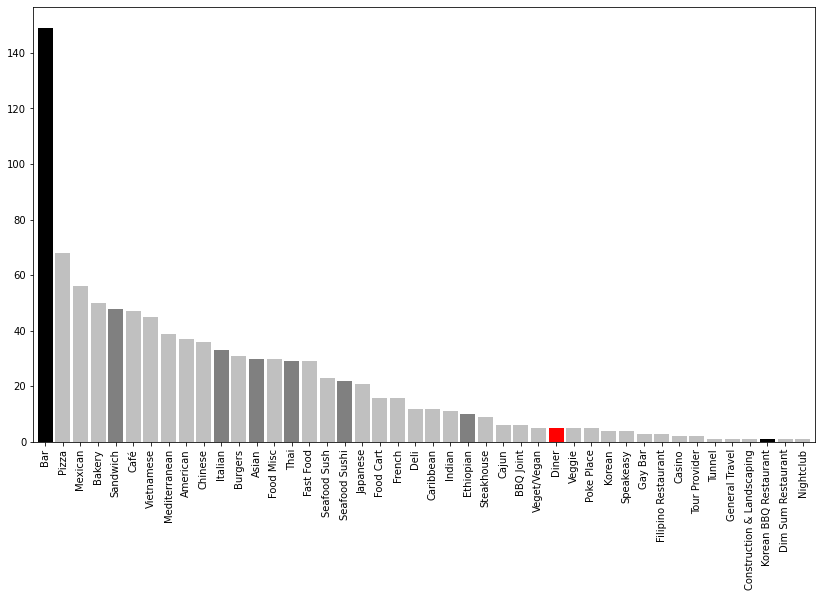

In [149]:
df_x = seattle_venues.drop(seattle_venues[seattle_venues["Venue Category"]=='Neighborhood'].index)

ax = df_x['Venue Category'].value_counts().plot(kind='bar', 
                                                   figsize=(14,8), 
                                                   width=.85,
                                                   color=['black','silver','silver','silver','gray','silver', 'silver','silver'
                                                          ,'silver','silver','gray','silver','gray','silver','gray','silver'
                                                          ,'silver','gray','silver','silver','silver','silver','silver','silver'
                                                          ,'gray','silver', 'silver','silver','silver'
                                                          ,'red'
                                                          ,'silver','silver','silver','silver','silver','silver', 'silver'
                                                          ,'silver','silver','silver','silver'
                                                         ])  

## 4.3 - Examine the Five Clusters
#### 4.3.1 - Cluster 1: "Saturated Urban Centers, Orient Places Already Established"
In this cluster, there are (6) zip codes, and every one has a Orient Restaurant; and they all rank 13th to 18th place out of the origina l278 categories. These markets are probably saturated unless the "client" has something unique to offer and compete on.  The Median age is 33-43.  The percent renters is high, ranging from 68% up to an astronomical 83%.

In [150]:
df_clus_1 = seattle_final.loc[seattle_final['Cluster Label'] == 0, seattle_final.columns[[0] + list(range(1, seattle_final.shape[1]))                                                                          ]]

# Analyze Cluster 1 for Patterns
print(df_clus_1.shape)
df_clus_1

(11, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,Rank=1,Rank=2,Rank=3,Rank=4,Rank=5,Rank=6,Rank=7,Rank=8,Rank=9,Rank=10,Rank=11,Rank=12,Rank=13,Rank=14,Rank=15,Rank=16,Rank=17,Rank=18,Rank=19,Rank=20
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98102,LakeUnion,Eastlake,Residential Urban Village,200.2,5084,37.00,25.394605,0.281591,0.718409,47.632870,-122.32253,False,0,Bar,Mexican,Bakery,American,Italian,Mediterranean,Sandwich,Steakhouse,Pizza,Café,Deli,Thai,Ethiopian,Asian,Food Cart,Seafood Sush,Gay Bar,Veget/Vegan,Indian,Vietnamese
98107,Ballard,Ballard,"Hub Urban Village, Manufacturing Industrial",1359.8,11736,39.55,8.630681,0.289776,0.710224,47.667470,-122.37468,False,0,Bar,Mexican,Pizza,American,French,Asian,Italian,Sandwich,Seafood Sushi,Burgers,Bakery,Thai,Food Cart,Seafood Sush,Mediterranean,Japanese,Food Misc,Vietnamese,Fast Food,BBQ Joint
98108,Duwamish,SouthPark,Residential Urban Village,263.4,3448,35.00,13.090357,0.500874,0.499126,47.546188,-122.31514,False,0,Bar,Pizza,Mexican,Japanese,Food Misc,Café,Food Cart,Fast Food,Sandwich,Seafood Sushi,French,Speakeasy,Diner,Construction & Landscaping,Mediterranean,Caribbean,Veggie,Burgers,Bakery,BBQ Joint
98109,LakeUnion,S_LakeUnion,Urban Center,339.9,3774,39.10,11.103266,0.124847,0.875153,47.630648,-122.34675,False,0,Bar,Mexican,Food Misc,Fast Food,Bakery,Korean,Italian,Food Cart,American,Steakhouse,Seafood Sush,Sandwich,Pizza,Mediterranean,Japanese,Asian,Vietnamese,Cajun,BBQ Joint,Café
98115,"Northeast, Northwest","Ravenna, GreenLake, Roosevelt","Urban Center Village, Residential Urban Village",389.2,8611,31.30,22.124872,0.200225,0.799775,47.683820,-122.30122,False,0,Bar,Pizza,Café,Mediterranean,American,Indian,Thai,Seafood Sushi,Sandwich,Japanese,Vietnamese,Chinese,Burgers,Bakery,Mexican,Caribbean,Veget/Vegan,Cajun,Food Cart,Steakhouse
98117,"Ballard, Northwest","CrownHill, Grnwd_Phinney",Residential Urban Village,267.1,5386,37.95,20.164732,0.447928,0.552072,47.685919,-122.37838,False,0,Bar,Pizza,Mexican,Café,Mediterranean,Food Misc,Fast Food,Bakery,Burgers,Sandwich,Deli,French,Food Cart,American,Thai,Italian,Vietnamese,Caribbean,,
98118,"Southeast, Duwamish","Othello, ColumbiaCity",Residential Urban Village,687.6,11204,34.25,16.294357,0.312762,0.687238,47.543348,-122.27496,False,0,Vietnamese,Bar,Bakery,Food Misc,Fast Food,Chinese,Pizza,Asian,Mexican,Dim Sum Restaurant,Italian,Food Cart,Ethiopian,Mediterranean,Cajun,Café,Burgers,,,
98119,Downtown,Uptown,Urban Center,333.1,7300,34.50,21.915341,0.222092,0.777908,47.638770,-122.36694,False,0,Bar,Bakery,Pizza,Sandwich,Food Misc,Mexican,American,Thai,Café,Italian,Fast Food,Seafood Sushi,Mediterranean,Japanese,Asian,Vietnamese,Burgers,Chinese,,
98125,"North, Northwest","LakeCity, Northgate","Hub Urban Village, Urban Center",552.8,10268,35.55,18.574530,0.174983,0.825017,47.716648,-122.30308,False,0,Bar,Mediterranean,Café,Mexican,Thai,Pizza,Vietnamese,Sandwich,Seafood Sushi,Ethiopian,Bakery,Burgers,Asian,Food Misc,,,,,,


#### 4.3.2 - Cluster 2: "The Target Locations"
In this cluster, there are (10) zip codes, and NOT ONE of them has a Orient Restaurant within 20 blocks!  The Median age is relatively young, ranging between 31 to 39.  The percent renters is generally in the 70's except for South Park and Crown Hill neighborhoods where ownership is surprisingly high -- of course we want to target the take-out crowd which tends to be renters.  Many of these zipcodes are good candidates for opening a Orient restaurant.  These are the Green Dots back on the map above for a reason!

In [151]:
df_clus_2 = seattle_final.loc[seattle_final['Cluster Label'] == 1, seattle_final.columns[[0] + list(range(1, seattle_final.shape[1]))                                                                          ]]

# Analyze Cluster 2 for Patterns
print(df_clus_2.shape)
df_clus_2

(5, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,Rank=1,Rank=2,Rank=3,Rank=4,Rank=5,Rank=6,Rank=7,Rank=8,Rank=9,Rank=10,Rank=11,Rank=12,Rank=13,Rank=14,Rank=15,Rank=16,Rank=17,Rank=18,Rank=19,Rank=20
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98101,"Downtown, East","CommCore, PikePine, DennyTriangle",Urban Center Village,550.0,13578,38.133333,24.687273,0.217482,0.782518,47.610670,-122.33438,True,1,Bakery,Bar,American,Mediterranean,Café,Sandwich,Italian,Chinese,Pizza,Seafood Sush,Seafood Sushi,French,Food Misc,Poke Place,Steakhouse,Tour Provider,Japanese,Veggie,Vietnamese,Deli
98103,"LakeUnion, Northwest","Wallingford, AuroraNorth, Fremont","Residential Urban Village, Hub Urban Village",798.6,15489,33.566667,19.395192,0.335741,0.664259,47.671346,-122.34166,True,1,Bar,Burgers,Pizza,Mexican,Thai,Japanese,Café,Asian,Food Misc,Seafood Sushi,American,Caribbean,Bakery,Food Cart,Poke Place,Seafood Sush,Chinese,Diner,Fast Food,Mediterranean
98104,"Downtown, East","MadisonMiller, FirstHill, PioneerSquare","Residential Urban Village, Urban Center Village",515.8,14999,39.833333,29.079100,0.169605,0.830395,47.602520,-122.32855,True,1,Vietnamese,Bar,Seafood Sush,American,Chinese,Italian,Seafood Sushi,Pizza,Food Misc,Sandwich,Asian,French,Bakery,Café,Poke Place,Veget/Vegan,Filipino Restaurant,Deli,Japanese,Steakhouse
98121,Downtown,Belltown,Urban Center Village,219.9,11961,39.800000,54.392906,0.235364,0.764636,47.614870,-122.34578,True,1,Bar,Bakery,Mediterranean,Seafood Sushi,Italian,Café,Seafood Sush,Pizza,French,American,Thai,Filipino Restaurant,Japanese,Veggie,Food Misc,Poke Place,Caribbean,Tour Provider,Deli,Speakeasy
98122,East,"IntDistrict, CapitolHill",Urban Center Village,568.7,21745,43.000000,38.236328,0.171637,0.828363,47.611570,-122.30406,True,1,Bar,Italian,Mediterranean,French,Vietnamese,Ethiopian,Thai,Bakery,Café,Mexican,Speakeasy,Asian,Gay Bar,Fast Food,American,Burgers,Diner,Pizza,Food Cart,Veget/Vegan


#### 4.3.3 - Cluster 3: "Outlier #1 - Too Sparse...Only 1 Zipcode and 3 Venue Categories"
This cluster is an outlier.  There is only one zipcode in this cluster, and only 3 rankings for Venue Categories.  It does not have a Orient place nearby.  The median age is 35.  The percent renters is almost 75%.  There are Vietnamese and Mediterranean restaurants as well as Pizza places; but nothing else.  This is probably not a good location for an upscale Orient Place.

In [152]:
df_clus_3 = seattle_final.loc[seattle_final['Cluster Label'] == 2, seattle_final.columns[[0] + list(range(1, seattle_final.shape[1]))                                                                          ]]

# Analyze Cluster 3 for Patterns
print(df_clus_3.shape)
df_clus_3

(1, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,Rank=1,Rank=2,Rank=3,Rank=4,Rank=5,Rank=6,Rank=7,Rank=8,Rank=9,Rank=10,Rank=11,Rank=12,Rank=13,Rank=14,Rank=15,Rank=16,Rank=17,Rank=18,Rank=19,Rank=20
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98177,Southeast,NorthRainier,Hub Urban Village,455.0,4908,39.7,10.786813,0.349586,0.650414,47.740886,-122.36978,False,2,Chinese,American,Seafood Sushi,Food Misc,Asian,,,,,,,,,,,,,,,


#### 4.3.4 - Cluster 4: "Possible Target Zone"
In this cluster, there are (7) zipcodes and NOT ONE of them has a Orient Restaurant within 20 blocks!  The median age ranges from 28 (in the University District) up to 45 in Duwamish (manufacturer area).  The Rental percent ranges from a low of 59% in Westwood up to a super high 94% in the University District.  Pizza, Thai, Vietnamese, and Asian cuisine are the top restaurant related Venue Categories.

In [153]:
df_clus_4 = seattle_final.loc[seattle_final['Cluster Label'] == 3, seattle_final.columns[[0] + list(range(1, seattle_final.shape[1]))                                                                          ]]

# Analyze Cluster 4 for Patterns
print(df_clus_4.shape)
df_clus_4

(7, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,Rank=1,Rank=2,Rank=3,Rank=4,Rank=5,Rank=6,Rank=7,Rank=8,Rank=9,Rank=10,Rank=11,Rank=12,Rank=13,Rank=14,Rank=15,Rank=16,Rank=17,Rank=18,Rank=19,Rank=20
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98105,Northeast,Admiral,Residential Urban Village,98.3,1528,42.30,15.544252,0.269231,0.730769,47.663770,-122.301180,False,3,Pizza,Café,Chinese,Vietnamese,Thai,Indian,Burgers,Bar,Bakery,Deli,Mediterranean,Italian,Veget/Vegan,Asian,Seafood Sush,Sandwich,Veggie,Mexican,Steakhouse,American
98106,Delridge,Westwood,Residential Urban Village,275.5,4606,36.80,16.718693,0.409465,0.590535,47.532820,-122.354430,False,3,Sandwich,Fast Food,Japanese,Bar,Burgers,Café,Mexican,Thai,Pizza,,,,,,,,,,,
98133,Northwest,BitterLake,Hub Urban Village,358.7,4273,37.90,11.912462,0.224715,0.775285,47.733852,-122.344610,False,3,Vietnamese,Asian,Thai,Bakery,Sandwich,Mexican,Chinese,Fast Food,Seafood Sush,Korean BBQ Restaurant,Korean,American,Café,Casino,Burgers,,,,,
98144,Duwamish,BeaconHill,Residential Urban Village,130.6,2900,38.90,22.205207,0.268178,0.731822,47.585770,-122.300810,False,3,Mexican,Pizza,Bar,Vietnamese,Sandwich,Bakery,Asian,Fast Food,Japanese,Chinese,Caribbean,Café,Food Misc,French,Nightclub,Seafood Sush,Mediterranean,Thai,Italian,Tunnel
98146,Southwest,WestSeattle,Hub Urban Village,225.8,3788,42.90,16.775908,0.323580,0.676420,47.501753,-122.356880,False,3,Fast Food,Pizza,Mexican,Asian,Bar,Burgers,Cajun,Food Cart,Japanese,Sandwich,,,,,,,,,,
98188,Duwamish,Duwamish,Manufacturing Industrial,4961.2,1064,44.50,0.214464,0.180473,0.819527,47.450321,-122.274720,False,3,Sandwich,Mexican,Chinese,American,Fast Food,Burgers,Thai,Italian,Indian,Steakhouse,Seafood Sushi,Seafood Sush,Pizza,Japanese,Asian,General Travel,Vietnamese,BBQ Joint,Bakery,Bar
98195,Northeast,"UnivDistrict, UnivCampus",Urban Center Village,635.0,19381,27.85,30.521260,0.060910,0.939090,47.651111,-122.311111,False,3,Sandwich,Café,Chinese,Vietnamese,Asian,Seafood Sush,Bar,Burgers,Mediterranean,Pizza,Italian,Indian,American,Deli,Thai,Mexican,Diner,Seafood Sushi,Korean,Steakhouse


#### 4.3.5 - Cluster 5: "Outlier #2 - Too Sparse...Only 1 Zipcode and 4 Venue Categories"


In [154]:
df_clus_5 = seattle_final.loc[seattle_final['Cluster Label'] == 4, seattle_final.columns[[0] + list(range(1, seattle_final.shape[1]))                                                                          ]]

# Analyze Cluster 5 for Patterns
print(df_clus_5.shape)
df_clus_5

(1, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,Rank=1,Rank=2,Rank=3,Rank=4,Rank=5,Rank=6,Rank=7,Rank=8,Rank=9,Rank=10,Rank=11,Rank=12,Rank=13,Rank=14,Rank=15,Rank=16,Rank=17,Rank=18,Rank=19,Rank=20
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98178,Southeast,RainierBeach,Residential Urban Village,267.5,3583,35.2,13.394393,0.25169,0.74831,47.497971,-122.24664,False,4,Vietnamese,Mediterranean,Cajun,Casino,Pizza,,,,,,,,,,,,,,,


## 5. Discussion <a name="Discussion"></a>

### 5.1  Cluster Analysis

Examination of the clusters readily indicates **Cluster #2** is best having all (10) zip codes absent of any Orient competition, yet has viable groups of restaurants near which to setup..  **Cluster #4** is similar having no Orient competition, but has fewer (7) available zip codes.  **Cluster #1** should be avoided unless the client has special advantages because these dense urban areas are already saturated with Orient competition.  **Clusters #3 and #5** are oddball outliers to be skipped, having just one zip code each and less than 4 venue categories (meaning few restaurant related venues).

### 5.2  Recommendations

Regarding the question “is there market potential for another Orient Restaurant in Seattle?”, the answer is absolutely Yes according to Fig. 4.2 above clearly showing the upside potential Orient restaurants have in the area.  The analysis in this report covered 2,055 venues in the Seattle area, of which 955 were restaurant related.   The analysis focused on venues within 20 blocks of the centroids of zip codes in the city of Seattle.  The tiny red bar on graph 4.2 represents the actual count of Orient restaurants in Seattle as of the evening of 1/1/2021 when this paper was being written.  There are just 10 Orient Places, with a few more possibly mis-classified in the 30 Sushi / Seafood restaurants and the 30-ish Japanese restaurants.
Regarding “what is the best location to open a new Orient restaurant in Seattle?”.  Well it depends.  The best zip codes according to cluster analysis are in clusters #2 and #4.   From there, you can drill down into the demographic data to spot upwardly mobile, younger demographic folks with a higher propensity towards eating out.  Since Orient would entail eating out, and Orient tends to be a little bit pricier than other dining options, then from Cluster #2, I’d recommend zip codes **98122** (Capital Hill), **98103** (Aurora North/Fremon), and **98121** (Belltown) as the best candidates.  


### 5.3  Discussion

There are several areas of improvement that should be considered for this research project.

1.	This was just a preliminary analysis that is part of an IBM Certification course.  If this were a real project with a real paying client, then even more rigor would go into factoring in features such as population, median income, densities, percent rental vs. ownership, etc.  

2.	The k-means modeling worked properly; however, could be improved by weighting features such as bus stations heavier rather than removing them from the model.  

3.	Note that the 20 block radius (1,600 meters) may have left some gaps or geographic areas not covered by FourSquare venues in the analysis.  As such, a follow-up study could be conducted to double or even triple the radius.  Such a follow-up study would need to focus more on the outer less dense areas of Seattle so as to avoid overcounting the denser zipcodes by 3x, 4x, or even 5x in the downtown core.

4.	Also, the FourSquare radius could be larger, then simply de-dup on the Venue returned name + latitude + longitude as a simple approach to increasing coverage but avoiding duplicates.

5.	I find it hard to believe that zip code 98195 in the University District has no Orient places (according to results from FourSquare).  Upon further digging, rank #6 is Japanese / Sushi restaurants.  I suspect a better grouping logic earlier at section 3.3.4.b the Venue Name Consolidation Scrub would have been to roll Sushi restaurants into the “Orient Place” bucket as they are a close competitor. Alternatively, perhaps the limit of 100 in that dense commercia/retail area just dropped out the Orient places.  Needs more research to improve accuracy


## 6. Conclusions <a name="Conclusions"></a>

This project set out to determine whether it was feasible to open a new Orient restaurant in Seattle, and if yes then what geographic location would be best.  Neighborhood data from the City of Seattle was used along with zip code data from a local company’s website.  That location data was augmented with venue data details from Foursquare and calculations applied in Python code.   This base data set was loaded, cleaned, and prepared so that cluster modeling and other analysis could be performed.  The Folium library was used for map related visualizations, and the standard python matplotlib was used for standard graphs.  This was a fun, but complex project, enjoyed working through it.

## 7. Footnotes <a name="footnotes"></a>

[1] https://www.coursera.org/professional-certificates/ibm-data-science#howItWorks  
[2] https://www.linkedin.com/in/naelqawass/
[3] https://nq.aibigdatasolutions.com/
[4] https://aibigdatasolutions.com/
  